In [ ]:
# This calculate the absolute magnitude of Altair, so as to determine 
# absolute magnitudes of fake companions for making a contrast curve

# Created 2020 Feb. 27 by E.S.

# For the math, see research notebook fizeau_altair.tex on date 2020 Feb. 27

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysynphot as S
import scipy
import os

%matplotlib qt

## Initialization

# Determine Altair absolute magnitude

### Set some constants

In [8]:
# distance of Altair
d_altair_pc = 5.13 # units pc (and plus/minus 0.015 pc)

# angular and physical radius of Altair
solar_radii_per_altair_radii = 1.65 # units of solar radii (ref: Table 1 in Monnier+ 2007)

m_per_au = 1.4959787066e11 # units meters
m_per_solar_radius = 6.95508e8 # units meters
au_per_pc = np.divide(360*60*60,2*np.pi) # units AU/pc

# distance of Altair in Altair radii (this should be about 1.4e8 altair radii)
d_altair_altair_radii = d_altair_pc*au_per_pc*np.divide(1.,m_per_solar_radius)*m_per_au*np.divide(1.,solar_radii_per_altair_radii)

# zero point on the Vega scale, specific to Paranal-NACO NB405 filter, from SVO filter service
# http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Paranal/NACO.NB405&&mode=browse&gname=Paranal&gname2=NACO#filter
zp_vega = 3.885e-12 # units erg /cm2 /sec /angstrom

##################################################################################################
# Surface flux of a model spectrum, based on a Kurucz model, courtesy SVO
# I tried to approximate parameters of Altair, which are 
# Teff=7550 K, logg=4.13, [Fe/H]=-0.24 \citep{erspamer2003automated}

## output from SVO:
# Kurucz ODFNEW /NOVER models
# teff = 7750 K (value for the effective temperature for the model. Temperatures are given in K)
# logg = 4.00 log(cm/s2) (value for Log(G) for the model.)
# meta = -0.5  (value for the Metallicity for the model.)
# lh = 1.25  (l/Hp where l is the  mixing length of the convective element and Hp is the pressure scale height)
# vtur = 2.0 km/s (Microturbulence velocity)
#
#                Filter #  Wavelength in Angstrom       #  Flux in erg/cm2/s/A
####################### #########################       ######################
#     Paranal/NACO.NB405           40555.445140895                 49610.952868

### ### IS THIS EVEN NEEDED? WE HAVE TO INTEGRATE OVER THE RESPONSE
model_flux_nb405 = 49610.952868 # units erg /cm2 /sec /angstrom 
# (note this is just a constant, implying spectrum is locally constant, which is fair given the narrowband filter)

### Read in filter curve

In [2]:
# NB405 filter

nb405_transmission = pd.read_csv("data/Paranal_NACO.NB405.dat.txt", 
                                 names=["wavel_angs", "transmission"], delim_whitespace=True)

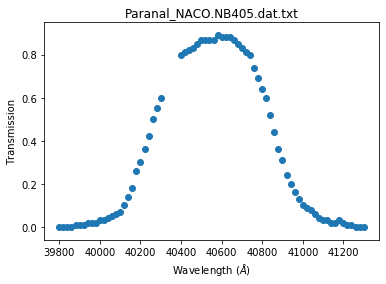

In [3]:
# plot filter

plt.clf()
plt.scatter(nb405_transmission["wavel_angs"],nb405_transmission["transmission"])
plt.title("Paranal_NACO.NB405.dat.txt")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Transmission")
plt.show()

### Read in model spectra (of a host star and Vega)

In [46]:
# Kurucz ODFNEW /NOVER models
# teff = 7750 K (value for the effective temperature for the model. Temperatures are given in K)
# logg = 4.00 log(cm/s2) (value for Log(G) for the model.)
# meta = 0  (value for the Metallicity for the model.)
# lh = 1.25  (l/Hp where l is the  mixing length of the convective element and Hp is the pressure scale height)
# vtur = 2.0 km/s (Microturbulence velocity)
#
# column 1: WAVELENGTH (ANGSTROM), Wavelength in Angstrom
# column 2: FLUX (ERG/CM2/S/A), Flux in erg/cm2/s/A

model_spectrum = pd.read_csv("data/model_spec_teff_7750_logg_4_feh_0.txt",
                             names=["wavel_angs", "flux"], skiprows=9, delim_whitespace=True)

In [47]:
# plot spectrum

plt.clf()
plt.scatter(model_spectrum["wavel_angs"],model_spectrum["flux"])
plt.title("Model spectrum in the region around the filter bandpass")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Surface flux (erg/cm2/s/$\AA$)")
plt.ylim([0,1e5])
plt.xlim([38000,42000])
plt.show()

In [48]:
# Vega spectrum is imported from pysynphot
# refs: 
# https://pysynphot.readthedocs.io
# https://www.stsci.edu/itt/review/synphot_2007/AppA_Catalogsa2.html

print("Vega flux units are")
print(S.Vega.fluxunits.name)

# flam = erg s−1 cm−2 \AA−1 (which is what I want! and at this amplitude it must be the flux at Earth)

Vega flux units are
flam


In [49]:
plt.clf()
plt.plot(S.Vega.wave, S.Vega.flux)
plt.scatter(nb405_transmission["wavel_angs"],np.max(S.Vega.flux)*nb405_transmission["transmission"],s=2,
            label="NB405 trans.")
plt.xlim(0, 50000)
plt.xlabel(S.Vega.waveunits)
plt.ylabel(S.Vega.fluxunits)
plt.title(os.path.basename(S.Vega.name) + "\nand filter transmission")
plt.show()

NameError: name 'os' is not defined

## Figure out what we want

### The equation for absolute magnitude (on the Vega scale) of a star we want to solve is
### $M_{ \textrm{star}} = m_{ \textrm{star}}  - 5\textrm{log}_{10}\left( \frac{\textrm{d}}{\textrm{10 pc}} \right)$
### where
### $m_{ \textrm{star}} = -2.5 \textrm{log}_{10} \left\{ \frac{\int d\lambda R_{\lambda}(\lambda) f_{\lambda}^{(0, star)}(\lambda) / \int d\lambda R_{\lambda}(\lambda) }{\textrm{zp}(f_{\lambda}^{(0, Vega)})}  \right\}$

### The equation for absolute magnitude (on the Vega scale) of a star we want to solve is
### $M_{ \textrm{star}} = m_{ \textrm{star}}  - 5\textrm{log}_{10}\left( \frac{\textrm{d}}{\textrm{10 pc}} \right)$
### where
### $m_{ \textrm{star}} = -2.5 \textrm{log}_{10} \left\{ \frac{\int d\lambda R_{\lambda}(\lambda) f_{\lambda,star}^{(0)}(\lambda)}{\int d\lambda R_{\lambda}(\lambda) }\right\} + 2.5 \textrm{log}_{10} \left\{ \textrm{zp}(f_{\lambda,Vega}^{(0)}) \right\}= -2.5 \textrm{log}_{10} \left\{ \frac{\int d\lambda R_{\lambda}(\lambda) f_{\lambda,star}^{(0)}(\lambda) / \int d\lambda R_{\lambda}(\lambda) }{\textrm{zp}(f_{\lambda, Vega}^{(0)})}  \right\}$
### The $(0)$ indicates 'at the top of Earth's atmosphere' and the zero point is defined on SVO page as
### $\textrm{zp}(f_{\lambda,Vega}^{(0)})\equiv \frac{ \int d\lambda R(\lambda)f_{\lambda,Vega}^{(0)}(\lambda)}{\int d\lambda R(\lambda)}$
### To find the expected flux of the star at the top of the Earth's atmosphere, use a synthetic spectrum (we are in the Rayleigh-Jeans regime for an Altair-like spectrum anyway) and scale it for distance:
### $f_{\lambda, star}^{(0)}(\lambda) = \left( \frac{R_{star}}{D} \right)^{2} f_{\lambda,star}^{(surf)}(\lambda) $
### Putting all the pieces together in terms of fundamental measurables, we want to calculate
### $M_{ \textrm{star}} = -2.5 \textrm{log}_{10} \left\{ \left( \frac{R_{star}}{D} \right)^{2}\frac{\int d\lambda R_{\lambda}(\lambda) f_{\lambda,star}^{(surf)}(\lambda) / \int d\lambda R_{\lambda}(\lambda) }{\textrm{zp}(f_{\lambda, Vega}^{(0)})}  \right\}   - 5\textrm{log}_{10}\left( \frac{\textrm{d}}{\textrm{10 pc}} \right)$
### or in code variables,
### $M_{ \textrm{star}} = -2.5 \textrm{log}_{10} \left\{ \textrm{piece_A}\frac{\textrm{piece_B} / \textrm{piece_C} }{\textrm{zp_vega}} \right\}   - 5\textrm{log}_{10}\left( \textrm{piece_D} \right)$

## Calculate the pieces

### $\textrm{piece_A}$: Calculate inverse-square law scaling factor to convert surface flux $f_{\lambda}^{(surf, star)}(\lambda)$ to flux at top of Earth's atmosphere:
### $\textrm{piece_A} \equiv \left( \frac{R_{star}}{D} \right)^{2} $

In [11]:
piece_A = np.power(np.divide(1.,d_altair_altair_radii),2.)

### $\textrm{piece_B}$: Integration of star flux and filter response: 
### $\textrm{piece_B} \equiv \int d\lambda R_{\lambda}(\lambda) f_{\lambda,star}^{(surf)}(\lambda) $

In [16]:
# To do the integration over two functions represented by input arrays, use the abcissa
# of the filter transmission $R$ to make an interpolated form of $f$ pinned to the same 
# ordinate. Then multiply the two arrays together and integrate over that.

model_surf_flux_filter_abcissa = np.interp(nb405_transmission["wavel_angs"].values, 
                                             model_spectrum["wavel_angs"].values,
                                             model_spectrum["flux"].values)

In [17]:
# now multiply the surface flux by the filter transmission to obtain the integrand

integrand_piece_B = np.multiply(nb405_transmission["transmission"],model_surf_flux_filter_abcissa)

In [23]:
# integrate 

piece_B = np.trapz(integrand_piece_B,x=nb405_transmission["wavel_angs"])

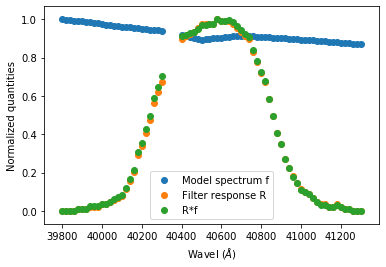

In [21]:
# plot everything so far

plt.clf()
plt.scatter(nb405_transmission["wavel_angs"],
            np.divide(model_surf_flux_filter_abcissa,np.max(model_surf_flux_filter_abcissa)),
            label="Model spectrum f")
plt.scatter(nb405_transmission["wavel_angs"],
            np.divide(nb405_transmission["transmission"],np.max(nb405_transmission["transmission"])),
            label="Filter response R")
plt.scatter(nb405_transmission["wavel_angs"],
            np.divide(integrand_piece_B,np.max(integrand_piece_B)),
            label="R*f")
plt.legend()
plt.xlabel("Wavel ($\AA$)")
plt.ylabel("Normalized quantities")
plt.show()

### $\textrm{piece_C}$: The normalization constant: 
### $\textrm{piece_C} \equiv \int d\lambda R_{\lambda}(\lambda) $

In [34]:
# integrate the filter transmission

piece_C = np.trapz(nb405_transmission["transmission"],x=nb405_transmission["wavel_angs"])

### $\textrm{piece_D}$: Multiples of 10 pc: 
### $\textrm{piece_D} \equiv \frac{\textrm{5.13 pc}}{\textrm{10 pc}} $

In [36]:
piece_D = np.divide(5.13,10)

### Also check the zero point given by SVO:

### $\textrm{zp_vega} \equiv \frac{\int d\lambda R_{\lambda} f_{Vega}^{(0)}}{\int d\lambda R_{\lambda}} \equiv \frac{\textrm{piece_vega}}{\textrm{piece_C}} $

### SVO value is 3.885e-12	(erg/cm2/s/A)

In [58]:
## as SVO defines it

# interpolate to put Vega flux on same abcissa
vega_earth_flux_filter_abcissa = np.interp(nb405_transmission["wavel_angs"].values,
                                           S.Vega.wave, 
                                           S.Vega.flux)

# now multiply the surface flux by the filter transmission to obtain the integrand
integrand_piece_vega = np.multiply(nb405_transmission["transmission"],vega_earth_flux_filter_abcissa)

# integrate 
piece_vega = np.trapz(integrand_piece_vega,x=nb405_transmission["wavel_angs"])

zp_vega_svo_defined_calc = np.divide(piece_vega,piece_C)
print("zp_vega_svo_defined_calc:")
print(zp_vega_svo_defined_calc)

zp_vega_svo_defined_calc:
3.86068523708853e-12


### check value using other definition, with lambda inside integrand (which seems to appear in other Vega zero points):

### $\textrm{zp_vega_extra_lambd} \equiv \frac{\int d\lambda R_{\lambda} \lambda f_{Vega}^{(0)}}{\int d\lambda R_{\lambda} \lambda } \equiv \frac{\textrm{piece_vega_extra_lambd}}{\textrm{piece_C_extra_lambd}} $

In [59]:
# now multiply the surface flux by the filter transmission to obtain the integrand
integrand_piece_vega_extra_lambd = np.multiply(integrand_piece_vega,nb405_transmission["wavel_angs"])

# integrate to get numerator
piece_vega_extra_lambd = np.trapz(integrand_piece_vega_extra_lambd,x=nb405_transmission["wavel_angs"])

# integrand of denominator
integrand_piece_C_extra_lambd = np.multiply(nb405_transmission["transmission"],nb405_transmission["wavel_angs"])
  
# integrate to get denominator
piece_C_extra_lambd = np.trapz(integrand_piece_C_extra_lambd,x=nb405_transmission["wavel_angs"])

zp_vega_extra_lambda_calc = np.divide(piece_vega_extra_lambd,piece_C_extra_lambd)
print("zp_vega_extra_lambda_calc:")
print(zp_vega_extra_lambda_calc)

zp_vega_extra_lambda_calc:
3.860446341435048e-12


### ... so the zero points are virtually the same

### Put everything together to get an apparent magnitude. Reiterating, we want
### $M_{ \textrm{star}} = -2.5 \textrm{log}_{10} \left\{ \left( \frac{R_{star}}{D} \right)^{2}\frac{\int d\lambda R_{\lambda}(\lambda) f_{\lambda,star}^{(surf)}(\lambda) / \int d\lambda R_{\lambda}(\lambda) }{\textrm{zp}(f_{\lambda, Vega}^{(0)})}  \right\}   - 5\textrm{log}_{10}\left( \frac{\textrm{d}}{\textrm{10 pc}} \right)$
### $\equiv -2.5 \textrm{log}_{10} \left\{ \textrm{piece_A}\frac{\textrm{piece_B} / \textrm{piece_C} }{\textrm{zp_vega}} \right\}   - 5\textrm{log}_{10}\left( \textrm{piece_D} \right)$

## Put pieces together for finding M_star

In [60]:
print("piece_A:")
print(piece_A)

piece_A:
5.2557697086904734e-17


In [39]:
print("piece_B:")
print(piece_B)

piece_B:
27452472.059999995


In [40]:
print("piece_C:")
print(piece_C)

piece_C:
548.6


In [41]:
print("zp_vega:")
print(zp_vega)

zp_vega:
3.885e-12


In [42]:
print("piece_D:")
print(piece_D)

piece_D:
0.513


### Final answer

In [61]:
M_star = -2.5*np.log10(piece_A*np.divide(np.divide(piece_B,piece_C),zp_vega))-5*np.log10(piece_D)

In [62]:
print("M_star:")
print(M_star)

M_star:
1.8729857760567394


### Note 2MASS measured $m_{K}=0.0102$.
### Then, $M_{K}=m_{K}-5\textrm{log}_{10}\left(\frac{\textrm{5.13 pc}}{\textrm{10 pc}}\right) = 1.55$